In [ ]:
import torch
from diffusers import LDMPipeline, UNet2DModel, VQModel, DDIMScheduler
import torch.nn.utils.prune as prune

# Load the pretrained models and scheduler
unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

# Pruning function for the U-Net model
def prune_unet(unet_model, amount=0.3):
    """
    Applies pruning to the U-Net model's convolutional layers and returns the pruned model.

    Parameters:
        unet_model (nn.Module): The U-Net model to prune.
        amount (float): The proportion of weights to prune in each layer (0 < amount < 1).

    Returns:
        nn.Module: The pruned U-Net model.
    """
    for name, module in unet_model.named_modules():
        # Prune only Conv2D layers
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            print(f"Pruned layer: {name} - amount: {amount}")

    # Permanently remove pruning masks to make pruning effective
    for name, module in unet_model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.remove(module, 'weight')
            print(f"Removed pruning reparameterization for layer: {name}")

    # Return the pruned model
    return unet_model

def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()
    sparsity = 100.0 * zero_params / total_params
    print(f"Sparsity: {sparsity:.2f}%")
    print(f"Total Parameters: {total_params}, Zeroed Parameters: {zero_params}")

calculate_sparsity(unet)

# Apply pruning to the U-Net model
unet = prune_unet(unet, amount=0.3)
vqvae = prune_unet(vqvae, amount=0.3)

# Initialize the pipeline with the pruned U-Net
pipeline = LDMPipeline(
    unet=unet,
    vqvae=vqvae,
    scheduler=scheduler,
).to("cuda:1" if torch.cuda.is_available() else "cpu")

torch.save(unet.state_dict(), "pruned_unet_celebahq.pth")
print("Pruned model saved as pruned_unet_celebahq.pth")

# Show number of params
calculate_sparsity(unet)
calculate_sparsity(vqvae)


2024-11-27 15:27:41.705499: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 15:27:41.741814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 15:27:41.741846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 15:27:41.742659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 15:27:41.748372: I tensorflow/core/platform/cpu_feature_guar

Sparsity: 0.00%
Total Parameters: 273915936, Zeroed Parameters: 0
Pruned layer: conv_in - amount: 0.3
Pruned layer: down_blocks.0.resnets.0.conv1 - amount: 0.3
Pruned layer: down_blocks.0.resnets.0.conv2 - amount: 0.3
Pruned layer: down_blocks.0.resnets.1.conv1 - amount: 0.3
Pruned layer: down_blocks.0.resnets.1.conv2 - amount: 0.3
Pruned layer: down_blocks.0.downsamplers.0.conv - amount: 0.3
Pruned layer: down_blocks.1.resnets.0.conv1 - amount: 0.3
Pruned layer: down_blocks.1.resnets.0.conv2 - amount: 0.3
Pruned layer: down_blocks.1.resnets.0.conv_shortcut - amount: 0.3
Pruned layer: down_blocks.1.resnets.1.conv1 - amount: 0.3
Pruned layer: down_blocks.1.resnets.1.conv2 - amount: 0.3
Pruned layer: down_blocks.1.downsamplers.0.conv - amount: 0.3
Pruned layer: down_blocks.2.resnets.0.conv1 - amount: 0.3
Pruned layer: down_blocks.2.resnets.0.conv2 - amount: 0.3
Pruned layer: down_blocks.2.resnets.0.conv_shortcut - amount: 0.3
Pruned layer: down_blocks.2.resnets.1.conv1 - amount: 0.3
Prun

  0%|          | 0/100 [00:00<?, ?it/s]

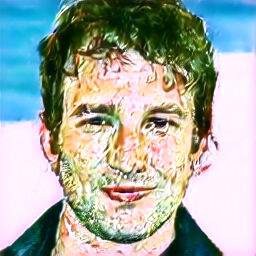

In [2]:
from IPython.display import display

# Define batch size and prompt
batch_size = 1

# Run the pipeline with the specified batch size
with torch.no_grad():
    generated_images = pipeline(batch_size=batch_size, num_inference_steps=100)

# Assuming `generated_images` is the output from the pipeline
generated_images_list = generated_images.images
display(generated_images_list[0])


Loading pre-trained models and scheduler...


An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Pruned models saved as pruned_unet_celebahq.pth and pruned_vqvae_celebahq.pth
Sparsity of U-Net: 25.07% (68674501/273915936)
Sparsity of VQ-VAE: 28.84% (15945456/55287954)
Initializing the LDMPipeline with pruned models...

Epoch 1/100


Training:   0%|          | 0/938 [00:00<?, ?it/s]/home/cqilab/anaconda3/envs/sgrs/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


KeyboardInterrupt: 

  0%|          | 0/100 [00:00<?, ?it/s]

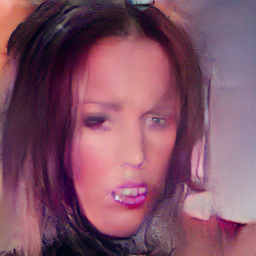

In [ ]:
calculate_sparsity(unet)

Sparsity of Model: 25.07% (68674501/273915936)


: 

2024-10-31 13:57:16.138706: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 13:57:16.171759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 13:57:16.171791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 13:57:16.172586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 13:57:16.177893: I tensorflow/core/platform/cpu_feature_guar

Warning! No positional inputs found for a module, assuming batch size is 1.
Warning! No positional inputs found for a module, assuming batch size is 1.
Pruning complete. #Params: 274.0562 M => 165.8026 M
#MACs: 96.0961 G => 55.6929 G
Pruned model saved to pruned_model


  0%|          | 0/100 [00:00<?, ?it/s]

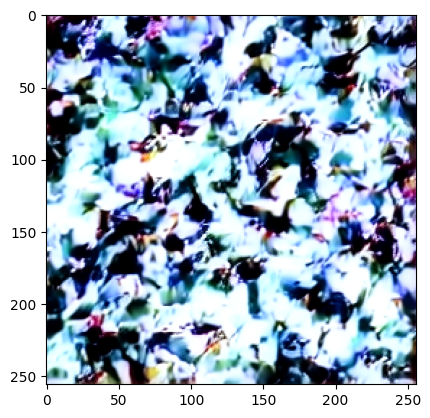

In [ ]:
# import torch
# from diffusers import LDMPipeline, UNet2DModel, VQModel, DDIMScheduler
# import torch_pruning as tp
# from diffusers.models.attention_processor import Attention
# import torchvision
# import os
# from PIL import Image
# import matplotlib.pyplot as plt


# # Load pretrained models and scheduler
# unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
# vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
# scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

# # Pruning function using torch-pruning's MagnitudePruner
# def prune_unet(unet_model, pruning_ratio=0.3, device='cpu'):
#     """
#     Applies structured pruning to the U-Net model's convolutional layers using the Magnitude Pruner.

#     Parameters:
#         unet_model (nn.Module): The U-Net model to prune.
#         pruning_ratio (float): The proportion of filters to prune in each layer (0 < pruning_ratio < 1).
#         device (str): Device to use for pruning, either 'cpu' or 'cuda'.

#     Returns:
#         nn.Module: The pruned U-Net model.
#     """
#     example_inputs = {'sample': torch.randn(1, unet_model.in_channels, unet_model.sample_size, unet_model.sample_size).to(device), 
#                       'timestep': torch.ones((1,)).long().to(device)}

#     imp = tp.importance.MagnitudeImportance(p=1)  # Pruning based on magnitude

#     # Define channel groups specifically for attention heads
#     channel_groups = {}
#     for m in unet_model.modules():
#         if isinstance(m, Attention):
#             channel_groups[m.to_q] = m.heads
#             channel_groups[m.to_k] = m.heads
#             channel_groups[m.to_v] = m.heads

#     # Define pruner with channel groups to maintain head consistency
#     ignored_layers = [unet_model.conv_out]
#     pruner = tp.pruner.MagnitudePruner(
#         unet_model,
#         example_inputs,
#         importance=imp,
#         iterative_steps=1,
#         ch_sparsity=pruning_ratio,
#         ignored_layers=ignored_layers,
#         channel_groups=channel_groups
#     )

#     base_macs, base_params = tp.utils.count_ops_and_params(unet_model, example_inputs)
    
#     unet_model.eval()
#     for group in pruner.step(interactive=True):
#         group.prune()

#     # Update attributes for compatibility
#     from diffusers.models.resnet import Upsample2D, Downsample2D
#     for m in unet_model.modules():
#         if isinstance(m, (Upsample2D, Downsample2D)):
#             m.channels = m.conv.in_channels
#             m.out_channels = m.conv.out_channels

#     macs, params = tp.utils.count_ops_and_params(unet_model, example_inputs)
#     print(f"Pruning complete. #Params: {base_params / 1e6:.4f} M => {params / 1e6:.4f} M")
#     print(f"#MACs: {base_macs / 1e9:.4f} G => {macs / 1e9:.4f} G")

#     return unet_model

# # Set pruning ratio and device
# pruning_ratio = 0.2
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Move models to device and apply pruning
# unet.to(device)
# unet = prune_unet(unet, pruning_ratio=pruning_ratio, device=device)

# # Initialize and save the pipeline with the pruned U-Net
# pipeline = LDMPipeline(
#     unet=unet,
#     vqvae=vqvae,
#     scheduler=scheduler,
# ).to(device)

# save_path = "pruned_model"
# os.makedirs(save_path, exist_ok=True)
# pipeline.save_pretrained(save_path)
# torch.save(unet.state_dict(), os.path.join(save_path, "unet_pruned.pth"))
# print(f"Pruned model saved to {save_path}")

# # Generate and save a sample image after pruning
# with torch.no_grad():
#     generator = torch.Generator(device=device).manual_seed(0)
#     images = pipeline(num_inference_steps=100, batch_size=1, output_type="numpy").images
#     os.makedirs(os.path.join(save_path, 'vis'), exist_ok=True)
#     torchvision.utils.save_image(torch.from_numpy(images).permute([0, 3, 1, 2]), f"{save_path}/vis/after_pruning.png")
    
# # Show the Image
# img = Image.open("pruned_model/vis/after_pruning.png")
# plt.imshow(img)
